# Model 3: Scenario & Robustness Analysis

Building on Model 2's dynamic framework, this 
model introduces "what-if" scenarios to test the strategy's robustness against key uncertainties. 
It evaluates performance against risks like volatile resource prices and increased bidding 
competition. The analysis also incorporates major policy and  environmental variables by 
modelling the financial impact of a new, tech-specific carbon tax. Finally, it simulates weather-
driven revenue fluctuations for renewables by applying variable capacity factors (good vs. bad 
years) to the revenue streams.

##### Notebook Outline
1) Imports
2) Load Input Data
3) Scenario Parameters
4) Gurobi Model Setup
5) Results
6) Visualizations

### Imports

In [53]:
import json
from pathlib import Path
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

### Load input data

In [54]:
# technology data
data_path = Path("data") / "technology_data.json"

with data_path.open("r", encoding="utf-8") as f:
    technology_data = json.load(f)

TECHNOLOGY_UNITS = technology_data["TECHNOLOGY_UNITS"]  
TECHNOLOGY_DATA = technology_data["TECHNOLOGY_DATA"]

df_units = pd.DataFrame(list(TECHNOLOGY_UNITS.items()), columns=["Parameter", "Unit"])
df_tech = pd.DataFrame(TECHNOLOGY_DATA).reset_index().rename(columns={"index": "parameter"})
df = df_units.merge(df_tech, left_on="Parameter", right_on="parameter", how="right").drop(columns=["parameter"])
print("Technology Data:")
display(df)

# load electricity prices
price_data_path = Path("data") / "electricity_prices.xlsx"
df_prices = pd.read_excel(price_data_path)[["Year", "Price"]].iloc[:20]
df_prices["Year"] = df_prices["Year"].astype(int)
df_prices["Price"] = df_prices["Price"].astype(float)

exchange_rate = 7.4 # DKK to EUR
df_prices["Price"] = df_prices["Price"]/exchange_rate
price_list = df_prices["Price"].tolist()

df_display = df_prices.T
df_display.columns = df_prices["Year"].tolist()
df_display = df_display.drop("Year")
print("Electricity Prices (EUR/MWh):")
display(df_display)

# load co2 intensity for technologies
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "CO2 intensity": 0
}
costs = costs.value.unstack().fillna(defaults)

co2_intensity = {
    #"Gas turbine (simple cycle)": costs.at["gas", "CO2 intensity"],
    #"Natural gas engine plant":   costs.at["gas", "CO2 intensity"],
    "Diesel engine farm":         costs.at["gas", "CO2 intensity"]*1.2,
    "OCGT - Natural gas":         costs.at["gas", "CO2 intensity"],
    "Coal power plant":           costs.at["coal", "CO2 intensity"],
    "Nuclear power plant":        costs.at["nuclear", "CO2 intensity"],
    "Onshore wind":               costs.at["onwind", "CO2 intensity"],
    "Offshore wind (fixed)":      costs.at["offwind", "CO2 intensity"],
    "Utility-scale PV":           costs.at["solar-utility", "CO2 intensity"],
}

df_co2 = pd.DataFrame.from_dict(co2_intensity, orient="index", columns=["CO2 intensity (tCO2/MWh)"]).T
print("CO2 Intensity by Technology:")
display(df_co2)

net_capacity = pd.read_csv(Path("data") / "net_installed_capacity.csv")
# Drop the first (metadata) row, reset index, convert capacity columns to numeric and compute total (MW)
net_capacity = net_capacity.iloc[1:].reset_index(drop=True)

# Convert all columns except 'Year' to numeric (they are GW in the source)
num_cols = [c for c in net_capacity.columns if c != "Year"]
net_capacity[num_cols] = net_capacity[num_cols].apply(pd.to_numeric, errors="coerce")

# Sum capacities (assume values are in GW) and convert to MW
sum_capacity_gw = net_capacity[num_cols].sum().sum()
sum_capacity = sum_capacity_gw * 1e3  # MW

print("Net installed capacity (cleaned):")
display(net_capacity)
print(f"Total installed capacity in dataset: {sum_capacity:.2f} MW")

Technology Data:


,Parameter,Unit,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
0,nominal_investment_total,MEUR/MW_el,0.36,0.47,2.10,4.000,1.150,2.390,0.38
1,fixed_om_total,EUR/MW/year,8983.37,8236.12,34324.40,147700.000,16663.000,34000.000,9500.00
2,variable_om_total,EUR/MWh,6.38,4.79,3.21,20.000,0.000,0.000,0.00
3,elec_eff,fraction (0-1),0.35,0.41,0.52,0.360,0.410,0.520,0.16
4,technical_lifetime,years,25.00,25.00,25.00,60.000,30.000,30.000,35.00
5,construction_time,years,1.00,0.20,4.50,8.000,1.500,3.500,0.50
6,total_outage,fraction of time (0-1),0.01,0.01,0.00,0.001,0.023,0.025,NaN


Electricity Prices (EUR/MWh):


,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044
Price,90.598127,88.152135,83.576931,82.826762,80.538427,79.397276,74.590121,67.366515,64.427126,62.897569,58.468283,59.1168,59.890278,60.807289,61.886407,63.146206,64.605259,66.28214,68.195421,70.363677


CO2 Intensity by Technology:


,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
CO2 intensity (tCO2/MWh),0.2376,0.198,0.3361,0.0,0.0,0.0,0.0


Net installed capacity (cleaned):


,Year,Hydro Run-of-River,Biomass,Fossil hard coal,Fossil oil,Fossil gas,Other renewables,Waste,Wind offshore,Wind onshore,Solar AC
0,2025.0,0.01,1.75,3.02,0.96,1.57,0.14,0.38,2.65,4.86,3.73


Total installed capacity in dataset: 19070.00 MW


In [55]:
import pandas as pd

cost_list = costs.index.to_list()

# Search cost_list for items containing "diesel" (case-insensitive)
matches = [item for item in cost_list if "solar" in item.lower()]

print(f"Found {len(matches)} match(es):")
for m in matches:
    print(m)

# Optionally create a pandas Series for nicer display in the notebook
pd.Series(matches, name="technology")

Found 8 match(es):
central solar thermal
decentral solar thermal
solar
solar-rooftop
solar-rooftop commercial
solar-rooftop residential
solar-utility
solar-utility single-axis tracking


0                 central solar thermal
1               decentral solar thermal
2                                 solar
3                         solar-rooftop
4              solar-rooftop commercial
5             solar-rooftop residential
6                         solar-utility
7    solar-utility single-axis tracking
Name: technology, dtype: object

### Scenario Parameters

In [56]:
market_share = 0.10                               
num_periods = 20
time_periods = list(range(num_periods))
hours_per_year = 8760

initial_budget = 50                              # MEUR
base_demand = market_share * 35_250_000           # MWh
demand_growth_rate = 0.02                         # yearly growth

carbon_price = 83  # EUR/tCO2, taken from https://tradingeconomics.com/commodity/carbon
carbon_increase = 5  # EUR/tCO2 per year

net_revenue_factor = 0.7 

# Maximum cumulative installed capacity per tech (MW)
max_capacity = {
    #"Gas turbine (simple cycle)": market_share*1500,
    #"Natural gas engine plant":   market_share*1500,
    "Diesel engine farm":         market_share*sum_capacity*0.2,
    "OCGT - Natural gas":         market_share*sum_capacity*0.2,
    "Coal power plant":           market_share*sum_capacity*0.2,
    "Nuclear power plant":        market_share*sum_capacity*0.2,
    "Onshore wind":               market_share*sum_capacity*0.2,
    "Offshore wind (fixed)":      market_share*sum_capacity*0.2,
    "Utility-scale PV":           market_share*sum_capacity*0.2,
}

In [57]:
max_capacity

{'Diesel engine farm': np.float64(381.40000000000003),
 'OCGT - Natural gas': np.float64(381.40000000000003),
 'Coal power plant': np.float64(381.40000000000003),
 'Nuclear power plant': np.float64(381.40000000000003),
 'Onshore wind': np.float64(381.40000000000003),
 'Offshore wind (fixed)': np.float64(381.40000000000003),
 'Utility-scale PV': np.float64(381.40000000000003)}

#### Preprocessing - build parameter dictionaries

In [58]:
tech_names = list(TECHNOLOGY_DATA.keys())

# --- Technical & economic parameters ---
capex = {tech: TECHNOLOGY_DATA[tech]['nominal_investment_total']
         for tech in tech_names}

elec_eff = {tech: TECHNOLOGY_DATA[tech]['elec_eff']
            for tech in tech_names}

vom_eur = {tech: TECHNOLOGY_DATA[tech]['variable_om_total']
           for tech in tech_names}

vom_meur = {tech: vom_eur[tech] / 1e6
            for tech in tech_names}

fixed_om_eur = {tech: TECHNOLOGY_DATA[tech]['fixed_om_total']
                for tech in tech_names}

fixed_om_meur = {tech: fixed_om_eur[tech] / 1e6
                 for tech in tech_names}

# --- Demand curve ---
demand = {
    t: base_demand * ((1 + demand_growth_rate) ** t)
    for t in time_periods
}

# --- Prices ---
carbon_price_eur_per_tco2 = {
    t: carbon_price + carbon_increase*t     # EUR/tCO2
    for t in time_periods
}

carbon_price_meur_per_tco2 = {
    t: carbon_price_eur_per_tco2[t] / 1e6   # MEUR/tCO2
    for t in time_periods
}

blocks = [1, 2, 3]

Q_block = {}
for t in time_periods:
    Q_block[(t, 1)] = 0.25 * demand[t]  # first 25% at high price
    Q_block[(t, 2)] = 0.35 * demand[t]  # next 35%
    Q_block[(t, 3)] = 0.40 * demand[t]  # last 40%


In [59]:
# --- Price scenarios for robust optimization ---
import data.price_uncertainty as pu

num_scenarios = 100   # adjust as needed

# Generate a list of price paths (one list per scenario)
# Each element price_scenarios[s] is a list of prices over the planning horizon
price_scenarios = pu.generate_price_data(num_scenarios)

# Scenario index set
scenarios = list(range(num_scenarios))

# (Optional) infer time horizon from the generated paths
num_periods = len(price_scenarios[0])
time_periods = list(range(num_periods))

# Quick sanity checks (can be removed later)
assert len(price_scenarios) == num_scenarios
for s in scenarios:
    assert len(price_scenarios[s]) == num_periods, "All scenarios must have same length"

price_scenarios_meur = {}
for s in scenarios:
    price_scenarios_meur[s] = [p / 1e6 for p in price_scenarios[s]]  # MEUR/MWh

# apply time blocks to each scenario
pi_block = {}
for s in scenarios:
    for t in time_periods:
        p = price_scenarios_meur[s][t]  # in MEUR/MWh
        pi_block[(s, t, 1)] = (1.00 * p)   # block 1 = full price
        pi_block[(s, t, 2)] = (0.85 * p)   # block 2 = 15% lower
        pi_block[(s, t, 3)] = (0.60 * p)   # block 3 = 40% lower



### Gurobi Model Setup

#### Variables

In [60]:
model = gp.Model("Dynamic_Revenue_Maximization")

# Investment in new capacity [MW] in period t (here-and-now)
investment = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Investment"
)

# Available capacity [MW] in period t (accumulated, here and now)
capacity = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Capacity"
)

# Energy produced [MWh] by tech in period t, scenario s
energy = model.addVars(
    tech_names, time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Energy"
)

# Budget available in each period t, scenario s [MEUR]
budget = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Budget"
)

# Revenue in each period t, scenario s [MEUR]
revenue = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Revenue"
)

# Variable O&M cost in each period t, scenario s [MEUR]
op_cost = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="OperatingCost"
)

# Fixed O&M cost in each period t (same across scenarios) [MEUR]
fixed_om_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="FixedOMCost"
)

# CAPEX in each period t (same across scenarios) [MEUR]
capex_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="CapexCost"
)

# CO2 cost in each period t, scenario s [MEUR]
co2_cost = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="CO2Cost"
)

# Sales in each period t, block b, scenario s [MWh]
sales = model.addVars(
    time_periods, blocks, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Sales"
)

#### Model constraints

In [61]:
# print data for diesel engine farm
tech = "Diesel engine farm"

In [62]:
# Capacity accumulation (here-and-now, no scenarios)
for tech in tech_names:
    model.addConstr(capacity[tech, 0] == investment[tech, 0],
                    name=f"CapacityInit_{tech}")
    for t in time_periods[1:]:
        model.addConstr(
            capacity[tech, t] == capacity[tech, t-1] + investment[tech, t],
            name=f"CapacityAccum_{tech}_{t}"
        )

# Cumulative capacity limits (here-and-now)
for tech in tech_names:
    if tech in max_capacity:
        for t in time_periods:
            model.addConstr(
                capacity[tech, t] <= max_capacity[tech],
                name=f"MaxCap_{tech}_{t}"
            )

# Production limited by capacity * efficiency * hours (scenario-wise)
for tech in tech_names:
    for t in time_periods:
        for s in scenarios:
            model.addConstr(
                energy[tech, t, s] <= capacity[tech, t] * elec_eff[tech] * hours_per_year,
                name=f"ProdCap_{tech}_t{t}_s{s}"
            )

# ============================
# REVENUE & COST DEFINITIONS
# ============================

for t in time_periods:
    # CAPEX and fixed O&M: same across scenarios
    model.addConstr(
        capex_cost[t] == gp.quicksum(
            investment[tech, t] * capex[tech]
            for tech in tech_names
        ),
        name=f"CapexCostDef_{t}"
    )

    model.addConstr(
        fixed_om_cost[t] == gp.quicksum(
            capacity[tech, t] * fixed_om_meur[tech]
            for tech in tech_names
        ),
        name=f"FixedOMDef_{t}"
    )

    # Scenario-dependent parts
    for s in scenarios:
        # Block sales caps: Q_block is deterministic (no scenario index)
        for b in blocks:
            model.addConstr(
                sales[t, b, s] <= Q_block[(t, b)],
                name=f"SalesBlockCap_t{t}_b{b}_s{s}"
            )

        # Revenue with scenario-dependent price blocks
        model.addConstr(
            revenue[t, s] == gp.quicksum(
                sales[t, b, s] * pi_block[(s, t, b)]
                for b in blocks
            ),
            name=f"RevenueDef_t{t}_s{s}"
        )

        # Variable O&M (scenario-wise because energy is scenario-wise)
        model.addConstr(
            op_cost[t, s] == gp.quicksum(
                energy[tech, t, s] * vom_meur[tech]
                for tech in tech_names
            ),
            name=f"OpCostDef_t{t}_s{s}"
        )

        # CO2 cost (depends on scenario via energy)
        model.addConstr(
            co2_cost[t, s] == gp.quicksum(
                energy[tech, t, s]
                * co2_intensity[tech]
                * carbon_price_meur_per_tco2[t]
                for tech in tech_names
            ),
            name=f"CO2CostDef_t{t}_s{s}"
        )

# ============================
# BUDGET DYNAMICS (scenario-wise)
# ============================

for s in scenarios:
    # Initial budget is the same numeric value for all scenarios
    model.addConstr(
        budget[0, s] == initial_budget,
        name=f"BudgetInit_s{s}"
    )

    for t in time_periods:
        # Cannot invest more than available budget in any scenario
        model.addConstr(
            capex_cost[t] <= budget[t, s],
            name=f"InvLimit_t{t}_s{s}"
        )

        model.addConstr(
            budget[t, s] >= 0,
            name=f"BudgetNonNeg_t{t}_s{s}"
        )

        if t < num_periods - 1:
            model.addConstr(
                budget[t+1, s] ==
                budget[t, s]
                - capex_cost[t]
                + revenue[t, s]
                - op_cost[t, s]
                - fixed_om_cost[t]
                - co2_cost[t, s],
                name=f"BudgetDyn_t{t}_s{s}"
            )

# ============================
# ENERGY–SALES BALANCE (scenario-wise)
# ============================

for t in time_periods:
    for s in scenarios:
        model.addConstr(
            gp.quicksum(sales[t, b, s] for b in blocks) ==
            gp.quicksum(energy[tech, t, s] for tech in tech_names),
            name=f"SalesBalance_t{t}_s{s}"
        )

#### Objective Function + optimize

In [63]:
num_scenarios = len(scenarios)

model.setObjective(
    (1 / num_scenarios) * gp.quicksum(
        revenue[t, s]
        - op_cost[t, s]
        - co2_cost[t, s]
        - fixed_om_cost[t]
        - capex_cost[t]
        for s in scenarios
        for t in time_periods
    ),
    GRB.MAXIMIZE
)

model.optimize()


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 34320 rows, 28320 columns and 100273 nonzeros
Model fingerprint: 0xfccbe001
Coefficient statistics:
  Matrix range     [3e-06, 5e+03]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 2e+06]
Presolve removed 16248 rows and 7408 columns
Presolve time: 0.08s
Presolved: 18072 rows, 20912 columns, 79111 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 179
 AA' NZ     : 5.388e+04
 Factor NZ  : 3.378e+05 (roughly 20 MB of memory)
 Factor Ops : 1.368e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal     

#### Results

In [64]:
scenario_profits = {}

for s in scenarios:
    total_profit = sum(
        revenue[t, s].X
        - op_cost[t, s].X
        - co2_cost[t, s].X
        - fixed_om_cost[t].X
        - capex_cost[t].X
        for t in time_periods
    )
    scenario_profits[s] = total_profit

df_profit = pd.DataFrame.from_dict(scenario_profits, orient='index', columns=['Profit'])
df_profit.head()


,Profit
0,1681.141722
1,1513.355757
2,1670.452020
3,2219.048183
4,1911.079345


#### Core Performance Table 

In [65]:
expected_profit = df_profit.Profit.mean()
worst_profit = df_profit.Profit.min()
best_profit = df_profit.Profit.max()
profit_volatility = df_profit.Profit.std()
loss_probability = (df_profit.Profit < 0).mean() * 100
CVaR_10 = df_profit.Profit.nsmallest(int(0.1 * len(df_profit))).mean()  # Avg of worst 10%

print(f"Expected Profit: {expected_profit:.2f} MEUR")
print(f"Worst-Case Profit: {worst_profit:.2f} MEUR")
print(f"Best-Case Profit: {best_profit:.2f} MEUR")
print(f"Volatility (Std Dev): {profit_volatility:.2f} MEUR")
print(f"Probability of Loss: {loss_probability:.1f}%")
print(f"CVaR (10% worst): {CVaR_10:.2f} MEUR")


Expected Profit: 1894.60 MEUR
Worst-Case Profit: 1332.70 MEUR
Best-Case Profit: 2492.39 MEUR
Volatility (Std Dev): 230.13 MEUR
Probability of Loss: 0.0%
CVaR (10% worst): 1494.75 MEUR


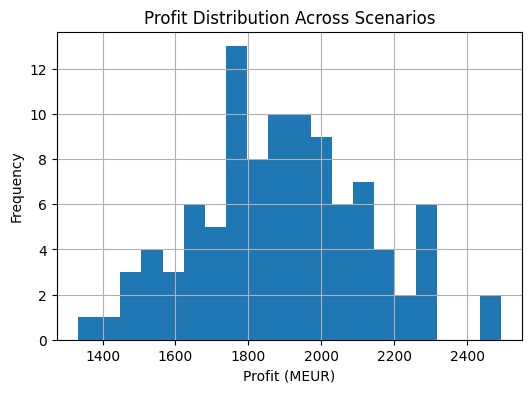

In [ ]:

df_profit.Profit.plot(kind='hist', bins=20, figsize=(6,4), title="Profit Distribution Across Scenarios")
plt.xlabel("Profit (MEUR)")
plt.grid(True)
plt.show()


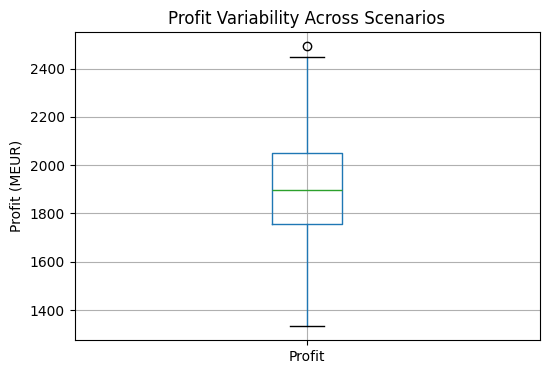

In [68]:
df_profit.boxplot(figsize=(6,4))
plt.title("Profit Variability Across Scenarios")
plt.ylabel("Profit (MEUR)")
plt.grid(True)
plt.show()


In [70]:
final_capacity = pd.Series({
    tech: capacity[tech, num_periods-1].X
    for tech in tech_names
}, name="Final Capacity (MW)")

display(final_capacity.sort_values(ascending=False))



OCGT - Natural gas       381.4
Utility-scale PV         381.4
Onshore wind             381.4
Coal power plant           0.0
Diesel engine farm         0.0
Nuclear power plant        0.0
Offshore wind (fixed)      0.0
Name: Final Capacity (MW), dtype: float64

In [73]:
energy_df = pd.DataFrame({
    (tech, s): sum(energy[tech, t, s].X for t in time_periods) / 1e3  # Convert to GWh
    for tech in tech_names
    for s in scenarios
}).T

energy_df.index = pd.MultiIndex.from_tuples(energy_df.index, names=['Technology', 'Scenario'])

display(energy_df)


ValueError: If using all scalar values, you must pass an index

In [64]:
if model.status != GRB.OPTIMAL:
    print(f"Model did not solve to optimality. Status: {model.status}")

else:
    print("Optimal solution found.\n")

    budget_df = pd.DataFrame({
        t: [budget[t].X]
        for t in time_periods
    }, index=["Budget (MEUR)"])

    print("---- Budget Evolution (MEUR) ----")
    display(budget_df)
    print()

    rev_cost_df = pd.DataFrame({
        t: {
            "Revenue (MEUR)":     revenue[t].X,
            "Var OPEX (MEUR)":    op_cost[t].X,
            "Fixed OPEX (MEUR)":  fixed_om_cost[t].X,
            "CAPEX (MEUR)":       capex_cost[t].X,
            "Net Cash Flow":      revenue[t].X - op_cost[t].X - capex_cost[t].X - fixed_om_cost[t].X
        }
        for t in time_periods
    })

    print("---- Revenue & Costs per Period (MEUR) ----")
    display(rev_cost_df)
    print()

    capacity_df = pd.DataFrame({
        t: {tech: capacity[tech, t].X for tech in tech_names}
        for t in time_periods
    })

    capacity_df.index.name = "Technology"

    capacity_df.loc["Total"] = capacity_df.sum(axis=0)

    print("---- Installed Capacity (MW) ----")
    display(capacity_df)
    print()

    production_df = pd.DataFrame({
        t: {tech: energy[tech, t].X/1e3 for tech in tech_names}
        for t in time_periods
    })

    production_df.index.name = "Technology"
    production_df.loc["Total"] = production_df.sum(axis=0)

    print("---- Energy Production (GWh) ----")
    display(production_df)
    print()

    totals_df = pd.DataFrame({
        "Total Revenue":      [sum(revenue[t].X for t in time_periods)],
        "Total Variable OPEX":[sum(op_cost[t].X for t in time_periods)],
        "Total Fixed OPEX":   [sum(fixed_om_cost[t].X for t in time_periods)],
        "Total CAPEX":        [sum(capex_cost[t].X for t in time_periods)],
        "Final Budget":       [budget[num_periods-1].X]
    })

    print("---- TOTALS OVER ALL PERIODS ----")
    display(totals_df)

Optimal solution found.

---- Budget Evolution (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Budget (MEUR),50.0,15.204048,17.258143,18.778015,21.686655,24.36705,27.859326,29.665616,29.284664,30.634065,32.422499,31.754775,63.817231,96.299403,129.330206,163.055655,197.63909,233.261412,270.121335,308.258925



---- Revenue & Costs per Period (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Revenue (MEUR),24.122352,26.931524,29.257825,33.010891,36.608428,41.084856,43.962605,44.589784,46.738484,49.345767,49.522806,50.205464,51.000155,51.923762,52.993383,54.226345,55.640208,57.252784,58.905427,60.778310
Var OPEX (MEUR),1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276
Fixed OPEX (MEUR),0.879433,1.259534,1.690988,2.160438,2.702604,3.311781,4.008264,4.641420,5.065742,5.509617,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405
CAPEX (MEUR),50.000000,15.204048,17.258143,18.778015,21.686655,24.367050,27.859326,29.665616,29.284664,30.634065,32.422499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Net Cash Flow,-28.571357,8.653667,8.494418,10.258162,10.404893,11.591749,10.280739,8.468472,10.573802,11.387810,9.306627,42.411783,43.206474,44.130081,45.199703,46.432664,47.846527,49.459103,51.111746,52.984629



---- Installed Capacity (MW) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OCGT - Natural gas,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082
Coal power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Nuclear power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Onshore wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.975266,34.440191,61.078508,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986
Offshore wind (fixed),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Utility-scale PV,1.143951,41.154603,86.570770,135.986599,193.056744,257.180561,330.494576,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000
Total,106.602033,146.612685,192.028851,241.444681,298.514826,362.638643,435.952658,495.833348,521.298273,547.936590,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068



---- Energy Production (GWh) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OCGT - Natural gas,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247
Coal power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Nuclear power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Onshore wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.235564,123.695388,219.369570,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264
Offshore wind (fixed),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Utility-scale PV,1.603362,57.682291,121.337591,190.598817,270.588333,360.464274,463.221198,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240
Total,380.366609,436.445539,500.100838,569.362064,649.351580,739.227521,841.984445,945.569051,1037.028876,1132.703057,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751



---- TOTALS OVER ALL PERIODS ----


,Total Revenue,Total Variable OPEX,Total Fixed OPEX,Total CAPEX,Final Budget
0,918.10116,36.285519,91.023866,297.160082,308.258925


In [40]:
if model.status != GRB.OPTIMAL:
    print(f"Model did not solve to optimality. Status: {model.status}")

else:
    print("\n🎯 Robust Optimal Solution Found\n")

    # Worst-case profit (objective value in robust model)
    print(f"📉 Worst-Case Profit (Model Objective): {model.objVal:.2f} MEUR")

    # Compare profit across scenarios
    print("\n📊 Profit per Scenario (MEUR):")
    for s in scenarios:
        profit_s = sum(
            revenue[t, s].X 
            - op_cost[t, s].X 
            - co2_cost[t, s].X
            - fixed_om_cost[t].X
            - capex_cost[t].X
            for t in time_periods
        )
        print(f"  Scenario {s}: {profit_s:.2f} MEUR")

    print("\n🏭 Final Installed Capacity (MW):")
    for tech in tech_names:
        print(f"  {tech}: {capacity[tech, num_periods-1].X:.1f} MW")

    print("\n💰 Final Budget by Scenario (MEUR):")
    for s in scenarios:
        print(f"  Scenario {s}: {budget[num_periods-1, s].X:.2f} MEUR")

    print("\n⚡ Total Energy Produced in Final Year (GWh):")
    for s in scenarios:
        energy_s = sum(energy[tech, num_periods-1, s].X for tech in tech_names) / 1e3
        print(f"  Scenario {s}: {energy_s:.2f} GWh")



🎯 Robust Optimal Solution Found

📉 Worst-Case Profit (Model Objective): 2184.27 MEUR

📊 Profit per Scenario (MEUR):
  Scenario 0: 1820.69 MEUR
  Scenario 1: 2320.10 MEUR
  Scenario 2: 2493.72 MEUR
  Scenario 3: 2114.78 MEUR
  Scenario 4: 2172.07 MEUR

🏭 Final Installed Capacity (MW):
  Diesel engine farm: 93.1 MW
  OCGT - Natural gas: 381.4 MW
  Coal power plant: 0.0 MW
  Nuclear power plant: 0.0 MW
  Onshore wind: 381.4 MW
  Offshore wind (fixed): 0.0 MW
  Utility-scale PV: 381.4 MW

💰 Final Budget by Scenario (MEUR):
  Scenario 0: 1706.57 MEUR
  Scenario 1: 2138.86 MEUR
  Scenario 2: 2348.61 MEUR
  Scenario 3: 1943.37 MEUR
  Scenario 4: 2036.94 MEUR

⚡ Total Energy Produced in Final Year (GWh):
  Scenario 0: 3274.24 GWh
  Scenario 1: 3559.75 GWh
  Scenario 2: 3559.75 GWh
  Scenario 3: 3559.75 GWh
  Scenario 4: 3559.75 GWh


#### Visualizations

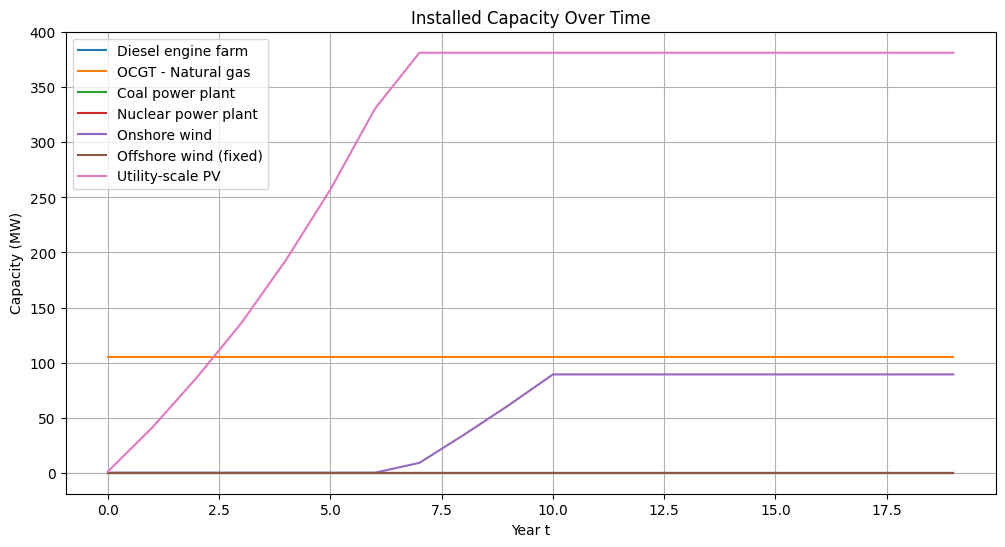

In [65]:
import matplotlib.pyplot as plt

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in cap_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Installed Capacity Over Time")
plt.xlabel("Year t")
plt.ylabel("Capacity (MW)")
plt.legend()
plt.grid(True)
plt.show()

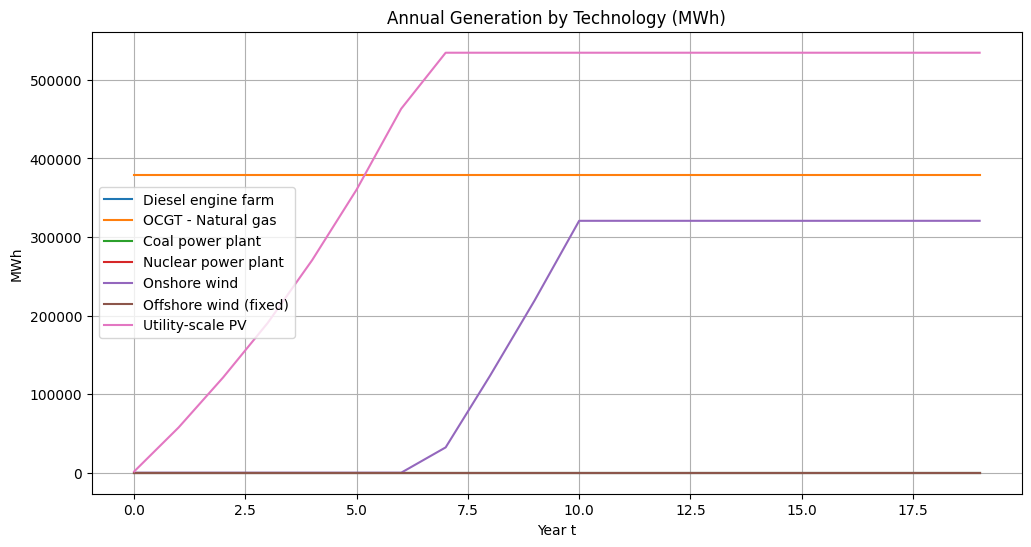

In [66]:
gen_plot = {tech: [energy[tech,t].X for t in time_periods]
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in gen_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Annual Generation by Technology (MWh)")
plt.xlabel("Year t")
plt.ylabel("MWh")
plt.legend()
plt.grid(True)
plt.show()

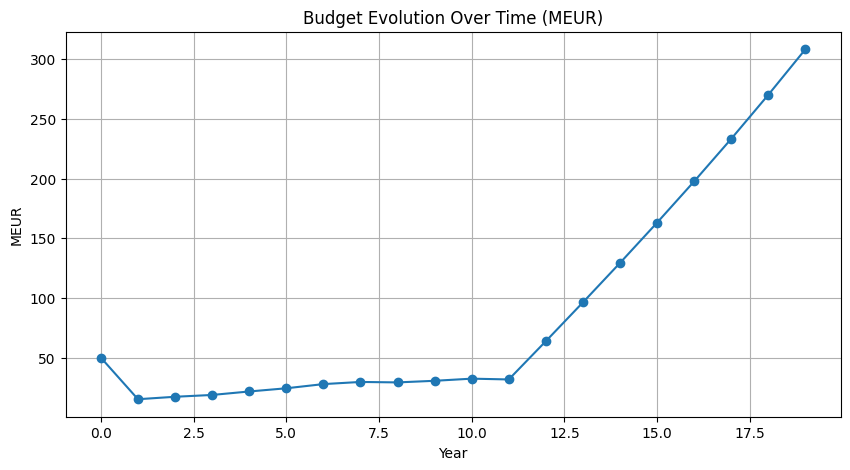

In [67]:
bud = [budget[t].X for t in time_periods]

plt.figure(figsize=(10,5))
plt.plot(time_periods, bud, marker="o")
plt.title("Budget Evolution Over Time (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.grid(True)
plt.show()

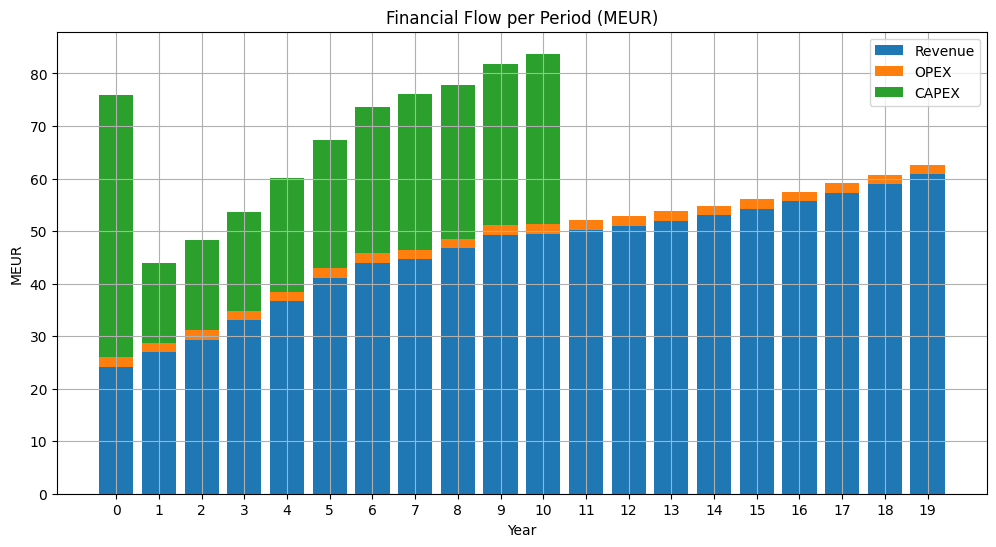

In [68]:
import numpy as np

rev = [revenue[t].X for t in time_periods]
op  = [op_cost[t].X for t in time_periods]
cap = [capex_cost[t].X for t in time_periods]

x = np.arange(len(time_periods))

plt.figure(figsize=(12,6))
plt.bar(x, rev, label="Revenue")
plt.bar(x, op, bottom=rev, label="OPEX")
plt.bar(x, cap, bottom=np.array(rev)+np.array(op), label="CAPEX")

plt.xticks(x, time_periods)
plt.title("Financial Flow per Period (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.legend()
plt.grid(True)
plt.show()

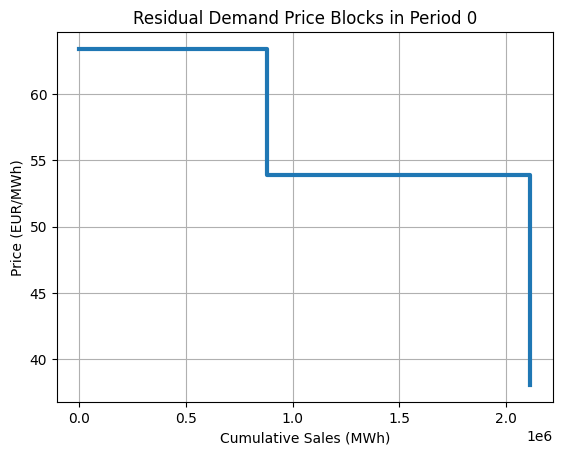

In [69]:
import matplotlib.pyplot as plt
import numpy as np

t = 0  # choose period to visualize (e.g., first year)

block_volumes = [Q_block[(t, b)] for b in blocks]
block_prices  = [pi_block[(t, b)]*1e6 for b in blocks]  # convert back to EUR/MWh

# Build stepwise curve
x_vals = [0]
y_vals = []

for b in blocks:
    x_vals.append(x_vals[-1] + block_volumes[b-1])
    y_vals.append(block_prices[b-1])

plt.step(x_vals[:-1], y_vals, where='post', linewidth=3)
plt.xlabel("Cumulative Sales (MWh)")
plt.ylabel("Price (EUR/MWh)")
plt.title(f"Residual Demand Price Blocks in Period {t}")
plt.grid(True)
plt.show()

In [70]:
sales_df = pd.DataFrame({
    f"Block {b}": [sales[t,b].X for t in time_periods]
    for b in blocks
})
sales_df["Total Sales"] = sales_df.sum(axis=1)
sales_df.index = [f"Period {t}" for t in time_periods]
sales_df

,Block 1,Block 2,Block 3,Total Sales
Period 0,3.803666e+05,0.000000,0.0,3.803666e+05
Period 1,4.364455e+05,0.000000,0.0,4.364455e+05
Period 2,5.001008e+05,0.000000,0.0,5.001008e+05
Period 3,5.693621e+05,0.000000,0.0,5.693621e+05
Period 4,6.493516e+05,0.000000,0.0,6.493516e+05
Period 5,7.392275e+05,0.000000,0.0,7.392275e+05
Period 6,8.419844e+05,0.000000,0.0,8.419844e+05
Period 7,9.455691e+05,0.000000,0.0,9.455691e+05
Period 8,1.032525e+06,4504.046046,0.0,1.037029e+06
Period 9,1.053175e+06,79527.731045,0.0,1.132703e+06


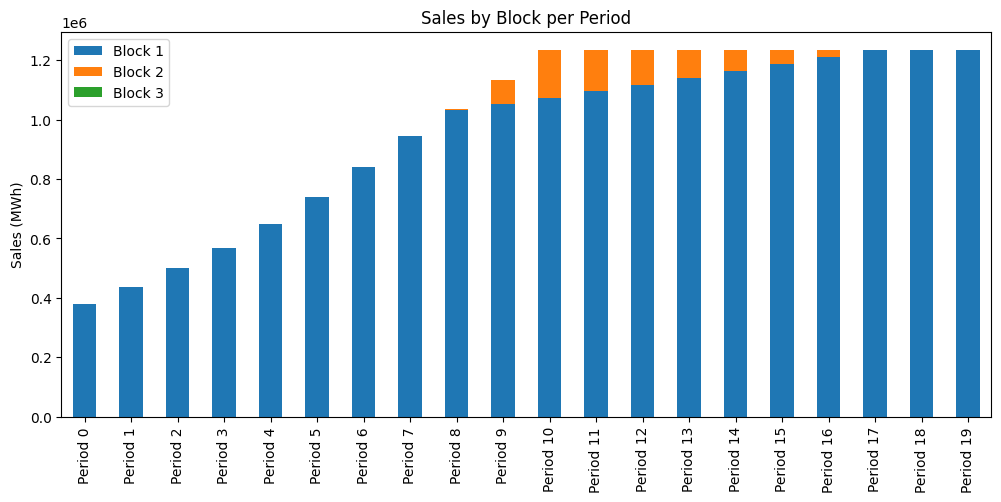

In [71]:
sales_df[["Block 1", "Block 2", "Block 3"]].plot(kind="bar", stacked=True, figsize=(12,5))
plt.ylabel("Sales (MWh)")
plt.title("Sales by Block per Period")
plt.show()

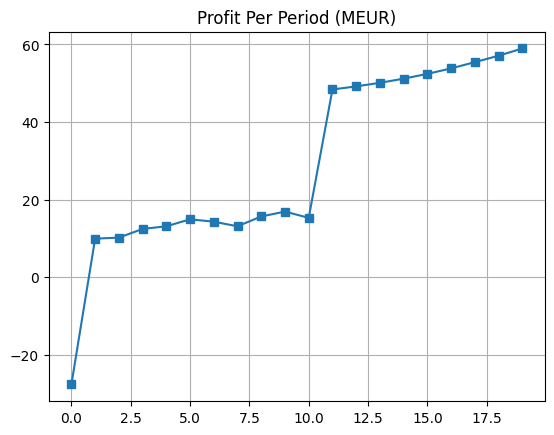

In [72]:
profit_t = [revenue[t].X - op_cost[t].X - capex_cost[t].X 
            for t in time_periods]

plt.plot(time_periods, profit_t, marker="s")
plt.title("Profit Per Period (MEUR)")
plt.grid(True)
plt.show()

#### Model Duals

In [73]:
for t in time_periods:
    constr = model.getConstrByName(f"DemandCap_{t}")
    print(f"Dual Demand Cap t={t}: {constr.Pi:.4f}")

AttributeError: 'NoneType' object has no attribute 'Pi'

In [ ]:
for tech in tech_names:
    for t in time_periods:
        c = model.getConstrByName(f"MaxCapacity_{tech}_{t}")
        if c is not None and abs(c.Pi) > 1e-6:
            print(f"{tech}, t={t}: shadow price = {c.Pi}")

In [ ]:
for t in time_periods:
    c = model.getConstrByName(f"InvLimit_{t}")   # capex_cost[t] <= budget[t]
    print(f"Shadow price investment limit t{t}: {c.Pi:.4f}")

Shadow price investment limit t0: 8.4407
Shadow price investment limit t1: 4.8919
Shadow price investment limit t2: 2.6760
Shadow price investment limit t3: 1.6783
Shadow price investment limit t4: 0.8610
Shadow price investment limit t5: 0.4283
Shadow price investment limit t6: 0.2820
Shadow price investment limit t7: 0.2118
Shadow price investment limit t8: 0.1164
Shadow price investment limit t9: 0.0000
Shadow price investment limit t10: 0.0000
Shadow price investment limit t11: 0.0000
Shadow price investment limit t12: 0.0000
Shadow price investment limit t13: 0.0000
Shadow price investment limit t14: 0.0000
Shadow price investment limit t15: 0.0000
Shadow price investment limit t16: 0.0000
Shadow price investment limit t17: 0.0000
Shadow price investment limit t18: 0.0000
Shadow price investment limit t19: 0.0000


In [ ]:
for t in time_periods[:-1]:
    c = model.getConstrByName(f"BudgetDyn_{t}")
    print(f"Shadow on budget recursion t={t}: {c.Pi:.4f}")

Shadow on budget recursion t=0: 11.1458
Shadow on budget recursion t=1: 6.2539
Shadow on budget recursion t=2: 3.5779
Shadow on budget recursion t=3: 1.8996
Shadow on budget recursion t=4: 1.0385
Shadow on budget recursion t=5: 0.6102
Shadow on budget recursion t=6: 0.3283
Shadow on budget recursion t=7: 0.1164
Shadow on budget recursion t=8: -0.0000
Shadow on budget recursion t=9: -0.0000
Shadow on budget recursion t=10: -0.0000
Shadow on budget recursion t=11: -0.0000
Shadow on budget recursion t=12: -0.0000
Shadow on budget recursion t=13: -0.0000
Shadow on budget recursion t=14: -0.0000
Shadow on budget recursion t=15: -0.0000
Shadow on budget recursion t=16: -0.0000
Shadow on budget recursion t=17: -0.0000
Shadow on budget recursion t=18: -0.0000
